In [2]:
import matplotlib.pyplot as plt
from scipy import stats
from covariance import Covariance
from cosmology import Cosmology
from powerspectra import Powerspectra
power=Powerspectra()
cov = Covariance()
cosmo = Cosmology()

In [46]:
fields = "kg"
fields = np.char.array(list(fields))
fish = Fisher()
def get_F_L_and_C_inv_splines(Lmax=5000): 
        sample_Ls = fish.covariance.get_log_sample_Ls(Lmin=2, Lmax=Lmax, Nells=50)
        sample_Ls, F_L, C_inv = fish.get_F_L(fields, Ls=sample_Ls, Ntheta=100, nu=353e9, return_C_inv=True)
        F_L_spline = InterpolatedUnivariateSpline(sample_Ls, F_L)
        N_fields = np.size(fields)
        C_inv_splines = np.empty((N_fields, N_fields), dtype=InterpolatedUnivariateSpline)
        Ls = np.arange(Lmax+1)
        for iii in range(N_fields):
            for jjj in range(N_fields):
                C_inv_ij = C_inv[iii, jjj]
                C_inv_splines[iii, jjj] = InterpolatedUnivariateSpline(Ls[2:], C_inv_ij[2:])
        return F_L_spline, C_inv_splines

In [47]:
F_L_spline, C_inv_spline = get_F_L_and_C_inv_splines()

In [85]:
import numpy as np
from fisher import Fisher
from fields import Fields
from powerspectra import Powerspectra
from cosmology import Cosmology
from scipy.interpolate import InterpolatedUnivariateSpline

class OmegaQE:

    def __init__(self, field_labels, N_pix=2 ** 7, Lmax=5000, kappa_map=None):
        self.fields = Fields(field_labels, N_pix, Lmax, kappa_map)
        self.L_map = self.fields.kM
        self.Lx_map, self.Ly_map = self._get_Lx_Ly_maps()
        self.Cls = dict.fromkeys(self.fields.fields)
        self.windows = dict.fromkeys(self.fields.fields)
        self.a_bars = dict.fromkeys(self.fields.fields)
        self._power = Powerspectra()
        self._cosmo = Cosmology()
        self.fish = fish
        self.F_L_spline, self.C_inv_spline = F_L_spline, C_inv_spline
        self.populate_a_bars()

    def _populate_Cls_and_windows(self, Chis):
        for field in self.fields.fields:
            self.Cls[field], self.windows[field] = self._get_ps_and_window(self.L_map, Chis, self._cosmo.get_chi_star(),
                                                                           field)

    def _get_ps_and_window(self, ells, Chis, Chi_source2, field, nu=353e9, gal_distro="LSST_gold"):
        shape_1, shape_2 = np.shape(self.L_map)
        if field == "k":
            Cl = self._power.get_kappa_ps_2source(ells.flatten(), Chis, Chi_source2)
            Cl = np.reshape(Cl, (shape_1, shape_2, np.size(Chis)))
            window = self._cosmo.cmb_lens_window(Chis, Chi_source2)
            return Cl, window
        if field == "g":
            Cl = self._power.get_gal_kappa_ps(ells.flatten(), Chis, gal_distro=gal_distro)
            Cl = np.reshape(Cl, (shape_1, shape_2, np.size(Chis)))
            window = self._cosmo.gal_window_Chi(Chis)
            return Cl, window
        if field == "I":
            Cl = self._power.get_cib_kappa_ps(ells.flatten(), nu=nu, Chi_source1=Chis)
            Cl = np.reshape(Cl, (shape_1, shape_2, np.size(Chis)))
            window = self._cosmo.cib_window_Chi(Chis, nu)
            return Cl, window

    def _get_Lx_Ly_maps(self):
        Lx, Ly = self.fields.get_kx_ky(self.fields.N_pix, self.fields.get_dist() / self.fields.N_pix)
        Lx_map = Lx[None, :] * np.ones(np.shape(self.fields.kM))
        Ly_map = Ly[:, None] * np.ones(np.shape(self.fields.kM))
        return Lx_map, Ly_map

    def _L_comp_map(self, index):
        if index == 0:
            return self.Lx_map
        if index == 1:
            return self.Ly_map

    def _get_f(self, i, p, r, weyl_ps, matter_weyl_ps, Chi_index):
        window = self.windows[i][Chi_index]
        L_map = self.L_map
        if i == "k":
            h = (L_map + 0.5) ** 4 * window * weyl_ps[:, :, Chi_index]
        else:
            h = -(L_map + 0.5) ** 2 * window * matter_weyl_ps[:, :, Chi_index]
        return self._L_comp_map(p) * self._L_comp_map(r) / ((L_map + 0.5) ** 2) * h

    def _get_g(self, i, p, r, Chi_index):
        return self._L_comp_map(p) * self._L_comp_map(r) / ((self.L_map + 0.5) ** 2) * self.Cls[i][:,:,Chi_index]

    def get_matter_ps(self, Chis):
        Chis = Chis[None, None, :]
        Ls = self.L_map[:, :, None]
        zs = self._cosmo.Chi_to_z(Chis)
        ks = (Ls + 0.5) / Chis
        weyl_PK = self._cosmo.get_matter_PK(typ="weyl")
        weyl_ps = self._cosmo.get_matter_ps(weyl_PK, zs, ks, weyl_scaled=False, typ="weyl")
        matter_weyl_PK = self._cosmo.get_matter_PK(typ="matter-weyl")
        matter_weyl_ps = self._cosmo.get_matter_ps(matter_weyl_PK, zs, ks, weyl_scaled=False, typ="matter-weyl")
        return weyl_ps, matter_weyl_ps

    def get_C_inv(self, typ):
        idx1 = np.where(self.fields.fields == typ[0])[0][0]
        idx2 = np.where(self.fields.fields == typ[1])[0][0]
        return self.C_inv_spline[idx1][idx2](self.L_map)
    
    def populate_a_bars(self):
        Ls = self.L_map.flatten()
        N_fields = np.size(self.fields.fields)
        a = np.zeros((np.size(Ls), N_fields, 1))
        C_inv = np.zeros((np.size(Ls), N_fields, N_fields))
        for iii, field_i in enumerate(self.fields.fields):
            a[:,iii, 0] = self.fields.fft_maps[field_i].flatten()
            for jjj, field_j in enumerate(self.fields.fields):
                C_inv[:,iii,jjj] = self.C_inv_spline[iii][jjj](Ls)
        a_bars = np.matmul(C_inv, a)
        for iii, field in enumerate(self.fields.fields):
            a_bar = a_bars[:,iii,0]
            self.a_bars[field] = np.reshape(a_bar, np.shape(self.L_map))


    def get_omega(self, Nchi=100, zmin=0, zmax=None, kmin=0, kmax=100, extended=True):
        Chis = np.linspace(0, self._cosmo.get_chi_star(), Nchi)[1:]
        dChi = Chis[1] - Chis[0]
        weyl_ps, matter_weyl_ps = self.get_matter_ps(Chis)
        self._populate_Cls_and_windows(Chis)
        r_s = [(0, 1), (1, 0)]
        
        omega_F = 0
        for i in self.fields.fields:
            for j in self.fields.fields:
                a_i = self.a_bars[i]
                a_j = self.a_bars[j]
                for p in range(2):
                    q = p
                    for r, s in r_s:
                        fac = -1 if r > s else 1
                        I_1 = np.zeros((self.fields.N_pix, self.fields.N_pix//2 + 1, np.size(Chis)),dtype="complex128")
                        I_2 = np.zeros((self.fields.N_pix, self.fields.N_pix//2 + 1, np.size(Chis)),dtype="complex128")
                        for Chi_index, Chi in enumerate(Chis):
                            F_i_fft = fac * self._get_f(i, p, r, weyl_ps, matter_weyl_ps, Chi_index) * a_i
                            G_j_fft = fac * self._get_g(j, q, s, Chi_index) * a_j
                            F_j_fft = fac * self._get_f(j, q, s, weyl_ps, matter_weyl_ps, Chi_index) * a_j
                            G_i_fft = fac * self._get_g(i, p, r, Chi_index) * a_i

                            F_i = np.fft.irfft2(F_i_fft, norm="ortho")
                            F_j = np.fft.irfft2(F_j_fft, norm="ortho")
                            G_i = np.fft.irfft2(G_i_fft, norm="ortho")
                            G_j = np.fft.irfft2(G_j_fft, norm="ortho")
                            
                            I_1[:,:,Chi_index] += np.fft.rfft2(F_i*G_j, norm="ortho")*(self.windows["k"]/(Chis**2))[Chi_index]
                            I_2[:,:,Chi_index] -= np.fft.rfft2(F_j*G_i, norm="ortho")*(self.windows["k"]/(Chis**2))[Chi_index]
                        
                        omega_F += dChi * np.sum(I_1, axis=2)
                        omega_F += dChi * np.sum(I_2, axis=2)
                        
        return(2*omega_F/self.F_L_spline(self.L_map))



In [86]:
%time qe = OmegaQE("kg")

CPU times: user 2min 42s, sys: 5.83 s, total: 2min 48s
Wall time: 21.5 s


In [87]:
%time omega = qe.get_omega()

CPU times: user 2min 18s, sys: 7.88 s, total: 2min 26s
Wall time: 49.8 s


In [88]:
print(omega)

[[ 1.91187951e-25+0.00000000e+00j  3.17602790e-25+0.00000000e+00j
  -5.17190871e-26+1.14839443e-41j ... -4.20237232e-29+3.73245640e-45j
  -8.95893008e-30+1.49781240e-44j -4.97894341e-29+0.00000000e+00j]
 [ 0.00000000e+00-4.40762413e-42j -5.75803631e-25+7.99088061e-42j
   4.40430159e-26+4.88975703e-42j ... -5.04294202e-29-7.46505379e-45j
  -3.58368989e-29-7.48930830e-45j  0.00000000e+00-6.58655061e-45j]
 [ 1.03438174e-25-5.74197214e-42j -2.64258095e-25+0.00000000e+00j
   5.86694644e-26-6.51361902e-42j ...  0.00000000e+00+7.46548181e-45j
   4.21652459e-29-3.74502615e-45j  1.18669585e-28-1.50571092e-44j]
 ...
 [-1.83440008e-25+0.00000000e+00j -1.41758780e-25-1.96729827e-42j
  -3.61953821e-26+0.00000000e+00j ...  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j -1.58970425e-29+0.00000000e+00j]
 [-2.06876349e-25-2.87098607e-42j  0.00000000e+00+9.77951407e-42j
   9.16710381e-28+0.00000000e+00j ... -3.36215411e-29+7.46548181e-45j
   0.00000000e+00+1.87251307e-45j  8.47639891e-

In [79]:
nBins=50
ps = np.real(np.conjugate(omega) * omega).flatten()
means, bin_edges, binnumber = stats.binned_statistic(qe.L_map.flatten(), ps, 'mean', bins=nBins)
binSeperation = bin_edges[1]
kBins = np.asarray([bin_edges[i] - binSeperation / 2 for i in range(1, len(bin_edges))])
counts, *others = stats.binned_statistic(qe.L_map.flatten(), ps, 'count', bins=nBins)
stds, *others = stats.binned_statistic(qe.L_map.flatten(), ps, 'std', bins=nBins)
errors = stds / np.sqrt(counts)

(30.0, 4000.0)

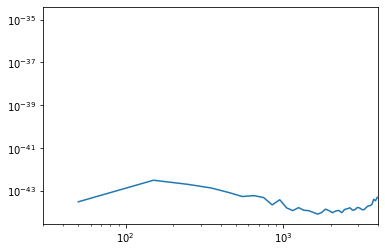

In [80]:
import matplotlib.pyplot as plt
plt.loglog(kBins, kBins**4*means/((2*np.pi**2)))
plt.xlim(3e1, 4e3)
# plt.ylim(9e-13,6e-11)

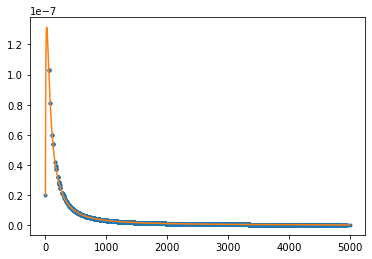

In [19]:
Nchi=100
Chis = np.linspace(0, cosmo.get_chi_star(), Nchi)[1:]
Chi_index=50
Cl_kk = qe.Cls["k"][:,:,Chi_index]
Ls_true=np.arange(0,5001)
Cl_kk_true = power.get_kappa_ps_2source(Ls_true,Chis[Chi_index], cosmo.get_chi_star())
Ls = qe.fields.kM.flatten()
plt.plot(Ls, Cl_kk.flatten(),".")
plt.plot(Ls_true, Cl_kk_true)

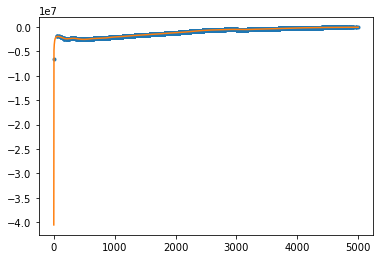

In [13]:
C_inv_kg = qe.get_C_inv("kg")
C_kk = cov.get_Cov("kk", ellmax=5000)
C_gg = cov.get_Cov("gg", ellmax=5000)
C_kg = cov.get_Cov("kg", ellmax=5000)
Ls = qe.fields.kM.flatten()
plt.plot(Ls, C_inv_kg.flatten(), ".")
Ls = np.arange(np.size(C_kk))
# plt.plot(Ls, C_gg/(C_kk*C_gg - C_kg**2))
plt.plot(Ls, -C_kg/(C_kk*C_gg - C_kg**2))
# plt.ylim(0, 3e7)

Matrix([[gg/(gg*kk - gk*kg), -kg/(gg*kk - gk*kg)], [-gk/(gg*kk - gk*kg), kk/(gg*kk - gk*kg)]])


(0.0, 30000000.0)

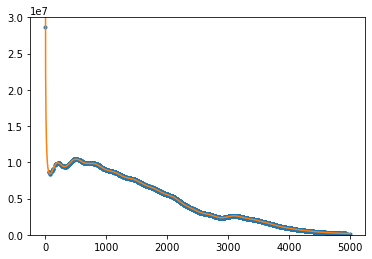

In [10]:
Ls = qe.fields.kM.flatten()
plt.plot(Ls, C_inv_kk.flatten(), ".")
C_inv = cov.get_C_inv("kg", 5000, 353e9)
Ls = np.arange(np.size(C_inv[0][0]))
plt.plot(Ls, C_inv[0][0])
plt.ylim(0, 3e7)

In [64]:
Chis = np.linspace(0, cosmo.get_chi_star(), 100)[1:]
dChi = Chis[1] - Chis[0]
weyl_ps, matter_weyl_ps = qe.get_matter_ps(Chis)

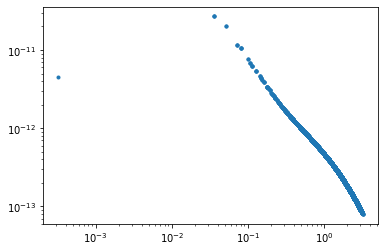

In [65]:
Chis = np.linspace(0, cosmo.get_chi_star(), 100)[1:]
Chis = Chis[None, None, :]
Ls = qe.fields.kM[:, :, None]
zs = cosmo.Chi_to_z(Chis)
ks = (Ls + 0.5) / Chis
Chi_index=10
weyl_ps_flat = weyl_ps[:,:,Chi_index].flatten()
ks = ks[:,:,Chi_index].flatten()
plt.loglog(ks, ks**4*weyl_ps_flat, ".")

In [34]:
from scipy import stats
nBins=30
ps = np.real(np.conjugate(qe.fields.fft_maps["g"]) * qe.fields.fft_maps["I"]).flatten()
means, bin_edges, binnumber = stats.binned_statistic(qe.L_map.flatten(), ps, 'mean', bins=nBins)
binSeperation = bin_edges[1]
kBins = np.asarray([bin_edges[i] - binSeperation / 2 for i in range(1, len(bin_edges))])
counts, *others = stats.binned_statistic(qe.L_map.flatten(), ps, 'count', bins=nBins)
stds, *others = stats.binned_statistic(qe.L_map.flatten(), ps, 'std', bins=nBins)
errors = stds / np.sqrt(counts)

<ErrorbarContainer object of 3 artists>

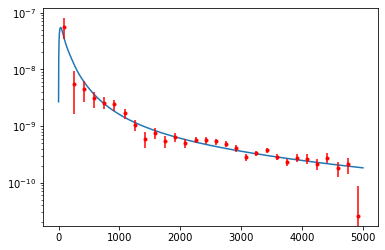

In [35]:
Cl_kg = cov.get_Cl("Ig", ellmax=5000)
plt.plot(np.arange(np.size(Cl_kg)), Cl_kg)
plt.semilogy(kBins, means, ".", color="red")
plt.errorbar(kBins, means, errors, ls="none", color="red")

In [15]:
_power = Powerspectra()
_cosmo=Cosmology()
_field = Fields("kgI")

In [18]:
Ls = _field.kM
Nchi=100
Chis = np.linspace(0, _cosmo.get_chi_star(), Nchi)[1:]
ps = _power.get_kappa_ps_2source(Ls.flatten(), Chis, _cosmo.get_chi_star())
print(np.shape(ps))

(8320, 99)


In [20]:
shape_1, shape_2 = np.shape(_field.kM)
ps = np.reshape(ps, (shape_1, shape_2,Nchi-1))
print(np.shape(ps))

(128, 65, 99)


In [30]:
Lx = np.arange(10)
Ly = np.arange(50,70)
Lx = Lx[None, :] * np.ones((20,10))
Ly = Ly[:, None] * np.ones((20,10))

In [31]:
print(Lx)

[[0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]
 [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]
 [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]
 [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]
 [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]
 [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]
 [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]
 [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]
 [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]
 [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]
 [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]
 [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]
 [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]
 [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]
 [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]
 [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]
 [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]
 [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]
 [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]
 [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]]


In [32]:
print(Ly)

[[50. 50. 50. 50. 50. 50. 50. 50. 50. 50.]
 [51. 51. 51. 51. 51. 51. 51. 51. 51. 51.]
 [52. 52. 52. 52. 52. 52. 52. 52. 52. 52.]
 [53. 53. 53. 53. 53. 53. 53. 53. 53. 53.]
 [54. 54. 54. 54. 54. 54. 54. 54. 54. 54.]
 [55. 55. 55. 55. 55. 55. 55. 55. 55. 55.]
 [56. 56. 56. 56. 56. 56. 56. 56. 56. 56.]
 [57. 57. 57. 57. 57. 57. 57. 57. 57. 57.]
 [58. 58. 58. 58. 58. 58. 58. 58. 58. 58.]
 [59. 59. 59. 59. 59. 59. 59. 59. 59. 59.]
 [60. 60. 60. 60. 60. 60. 60. 60. 60. 60.]
 [61. 61. 61. 61. 61. 61. 61. 61. 61. 61.]
 [62. 62. 62. 62. 62. 62. 62. 62. 62. 62.]
 [63. 63. 63. 63. 63. 63. 63. 63. 63. 63.]
 [64. 64. 64. 64. 64. 64. 64. 64. 64. 64.]
 [65. 65. 65. 65. 65. 65. 65. 65. 65. 65.]
 [66. 66. 66. 66. 66. 66. 66. 66. 66. 66.]
 [67. 67. 67. 67. 67. 67. 67. 67. 67. 67.]
 [68. 68. 68. 68. 68. 68. 68. 68. 68. 68.]
 [69. 69. 69. 69. 69. 69. 69. 69. 69. 69.]]


In [51]:
steps = np.ones(99)[None, None,:]

In [54]:
print(np.shape(ps))

(128, 65, 99)


In [57]:
print(np.shape(np.sum(ps, axis=2)))

(128, 65)
